In [26]:
### Running the mcmc with parallel tempered

import numpy as np
import emcee
from math import sqrt, pi, ceil
from matplotlib import pyplot as plt
%matplotlib inline
from emcee import PTSampler
from astropy.io import fits as pyfits
import corner

In [27]:
wlHa = 6562.8
wlNIIa = 6548.1
wlNIIb = 6583.5

par_fixha = ['continuum', 'redshift', 'flux Ha', 'flux NII']
par_slope = ['continuum', 'slope']
par_flat = ['continuum']

nwalkers = 100
nburn = 1000
nsamp = 1000

#output_path = '../mcmc_fits/galaxy_pages_{aper}_spb/F{field}/'
output_path = './omega-pipeline/output/'

In [31]:
def gaussian(x, ampl, centre, sigma):
    # with unit area
    return (ampl/(sigma*sqrt(2*pi))) * np.exp(-(x-centre)**2/(2.0*sigma**2))


class Softbox:
    """A soft-edged box function

    This produces a box over the range low to high, with soft edges.
    It has value one in the centre of the range, and decreases to
    edgelevel at the edges (x=low and x=high), and further decreases
    to cutofflevel after a further cutoffwidth, i.e. at x = low - cutoffwidth
    and vice versa.

    When an object is created, the initial parameters are tuned to give
    (approximately) the behaviour specified.  The object may then be called
    to obtain its value for different arguments.

    """

    def __init__(self, low, high, cutoffwidth,
                 edgelevel=0.9, cutofflevel=0.01):
        self.centre = 0.5 * (high + low)
        self.halfwidth = 0.5 * (high - low)
        index = (np.log(np.log(cutofflevel) / np.log(edgelevel)) /
                 np.log((self.halfwidth + cutoffwidth) / self.halfwidth))
        index = int(ceil(index))
        if index % 2 != 0:
            index += 1
        self.index = index
        print 'softbox index is', self.index
        self.sigma = -(self.halfwidth)**index / np.log(edgelevel)

    def __call__(self, x):
        return np.exp(-(x - self.centre)**self.index / self.sigma)


def fixha_model(x, p):
    model = p[0] + gaussian(x, p[2], (1+p[1])*wlHa, 7.5)
    model += gaussian(x, p[3]/3.06, (1+p[1])*wlNIIa, 7.5) + gaussian(x, p[3], (1+p[1])*wlNIIb, 7.5)
    return model


def slope_model(x, p, x0):
    model = p[0] + p[1] * (x - x0)
    return model


def flat_model(x, p):
    model = p[0] + np.zeros_like(x)
    return model


def lnprob_fixha(p, y, x, icov):
    model = fixha_model(x, p)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0


def lnprior_hard_fixha(p, zmin, zmax):
    # Here we set the hard priors:
    if (p[3] < 0) or (p[1] > zmax) or (p[1] < zmin) or ((p[3]/p[2]) > 3) or (p[3] > (3*p[2] + 3*p[0])):
        return -np.inf
    else:
        return 0.0


def lnprior_soft_fixha(p, xmin, xmax, ymax, softbox):
    continuum, redshift, fluxHa, fluxNII = p

    # inherit proper continuum prior
    lnprior = lnprior_flat(p, ymax)

    # proper priors on flux of each line: very broad Gaussian
    lnprior += np.log(gaussian(fluxHa, 1.0, ymax, 10*ymax))
    lnprior += np.log(gaussian(fluxNII, 1.0, ymax, 10*ymax))

    # strongly penalise negative NII flux
    # by prob of exp(-1) for each 10**-17 of negative flux
    lnprior += np.where(fluxHa < 0, fluxHa/1e17, 0)

    # Set edges of redshift box (prior > 0.9) such that
    # peak of Halpha is in the wavelength range
    zmin = xmin/wlHa - 1
    zmax = xmax/wlHa - 1
    # Set cutoffwidth such that prior ~< 0.01 by point at which
    # Halpha is out of wavelength range by 3 sigma
    lnprior += np.log(softbox(redshift))

    # Limit ratio fluxNII < (3*fluxHa + 3*continuum)
    # i.e. allow for up to an EW of 3A absorption
    # Penalise for exceeding this limit
    # by prob of exp(-1) for each 10% above the limit
    NIIHa_check = 1 - fluxNII / (3*fluxHa + 3*continuum)
    lnprior += np.where(NIIHa_check < 0, NIIHa_check/0.1, 0)

    return lnprior


def lnprior_slope(p, xmin, xmax, ymin, ymax):
    continuum, slope = p
    # inherit proper continuum prior
    lnprior = lnprior_flat(p, ymax)
    # proper prior on continuum: very broad Gaussian
    lnprior += np.log(gaussian(slope, 1.0, 0.0, (ymax - ymin) / (xmax - xmin)))
    return lnprior


def lnprior_flat(p, ymax):
    continuum = p[0]
    # proper prior on continuum: very broad Gaussian
    return np.log(gaussian(continuum, 1.0, ymax, 10 * ymax))


def lnprob_slope(p, y, x, icov, x0):
    model = slope_model(x, p, x0)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0


def lnprob_flat(p, y, x, icov):
    model = flat_model(x, p)
    chisq = ((model - y)**2 * icov).sum()
    return -chisq/2.0


def get_data(glx, field, aper):
    filetemplate=('../plot_aper/all_spectra_hst/'
                  'F{field}_spectrum_gal_{glx}_{aper}_hst.txt')
    filename = filetemplate.format(glx=glx, field=field, aper=aper)

    f = np.loadtxt(filename, dtype='g')
    xmeans, ymeans, error_flux = f[:,:3].T

    ## Getting rid of the nan values...
    ok = np.logical_not(np.isnan(ymeans) | np.isnan(error_flux))

    error_flux[error_flux == 0] = 1.0  # ARBITRARY?!?

    xmeans = xmeans[ok]
    ymeans = ymeans[ok]
    error_flux = error_flux[ok]
    xmin = np.min(xmeans)
    xmax = np.max(xmeans)
    ymin = np.min(ymeans)
    ymax = np.max(ymeans)
    icov = 1/error_flux**2
    zmax = (xmax+20)/wlHa - 1
    zmin = (xmin-20)/wlHa - 1
    return xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax


def init_p0_fixha(ymin, ymax, zmin, zmax):
    # very broad uniform initial distributions
    np.random.seed(1234)### Establish the same random numbers every time we run it!!
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    z_init = np.random.uniform(zmin, zmax, nwalkers)
    fha_init = (np.random.uniform(ymin, ymax, nwalkers) - ymin) * sqrt(2*pi) * 7.5
    fnii_init = (np.random.uniform(ymin, ymax, nwalkers) - ymin) * sqrt(2*pi) * 7.5
    return np.transpose([c0_init, z_init, fha_init, fnii_init])


def init_p0_slope(xmin, xmax, ymin, ymax):
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    maxslope = (ymax-ymin)/(xmax-xmin)
    c1_init = np.random.uniform(-maxslope, maxslope, nwalkers)
    return np.transpose([c0_init, c1_init])


def init_p0_flat(ymin, ymax):
    # very broad uniform initial distributions
    c0_init = np.random.uniform(ymin, ymax, nwalkers)
    return np.transpose([c0_init])


def flatten_without_burn(sampler, nburn):
    c = sampler.chain
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))


def weight_without_burn(sampler, nburn):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


def lnprobability_without_burn(sampler, nburn):
    c = sampler.lnprobability
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = c.reshape(np.product(c.shape))
    return w


def lnlikelihood_without_burn(sampler, nburn):
    c = sampler.lnlikelihood
    if c.ndim == 3:
        c = c[0]
    c = c[:, nburn:]
    w = np.exp(c.reshape(np.product(c.shape)))
    return w / w.sum()


def autocor_checks(sampler, aper, field, glx, nburn, label=''):
    a_exp = sampler.acor[0]
    a_int = np.max([emcee.autocorr.integrated_time(sampler.chain[0, i, nburn:])
                    for i in range(len(sampler.chain[0]))], 0)
    a_exp = max(a_exp)
    a_int = max(a_int)
    print('A reasonable burn-in should be around {:d} steps'.format(int(10*a_exp)))
    print('After burn-in, each chain produces one independent sample per {:d} steps'.format(int(a_int)))

    g = [emcee.autocorr.function(sampler.chain[0, i, :nburn])
         for i in range(3)]

    ax = plt.figure().add_subplot(111)
    for i in range(3):
        ax.plot(g[i][:200], "k")
    ax.axhline(0, color="k")
    ax.set_xlim(0, 200)
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Autocorrelation")
    plt.savefig((output_path + 'F{field}_mcmc_burnin_acor_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))

   ### Autocorrelation for AFTER the burn-in

    f = [emcee.autocorr.function(sampler.chain[0, i, nburn:])
         for i in range(3)]

    ax = plt.figure().add_subplot(111)
    for i in range(3):
        ax.plot(f[i][:200], "k")
    ax.axhline(0, color="k")
    ax.set_xlim(0, 200)
    ax.set_xlabel(r"$\tau$")
    ax.set_ylabel(r"Autocorrelation")
    plt.savefig((output_path + 'F{field}_mcmc_acor_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))

    ### gk_i es la suma de todos los valores anteriores del parametro gk en la cadena i dividido entre el numero de valores. Vamos, un valor medio.

    ### gk_twodots es la suma de todos los valores anteriores de gk en todas las cadenas dividido entre numero total de cadenas multiplicado por el numero de iterations.

    all_R_k = []
    gk_all = []
    B_over_q_each = []
    W_each = []

    # I SUSPECT THIS IS SLOW - ISN'T THERE A BETTER WAY?
    for qq in range(0,nsamp):
        for ll in range(0,nwalkers):

            gk_ll = sum(sampler.chain[0,ll,:qq,0])/nsamp
            gk_twodots = sum(sum(sampler.chain[0,:,:qq,0]))/(nsamp*nwalkers)

	    gk_ll_qq = sampler.chain[0,ll,qq,0]
            W_each.append((gk_ll_qq - gk_ll)**2)

            B_over_q_each.append(((gk_ll - gk_twodots)**2))

        B_over_q_total = sum(B_over_q_each)/(nwalkers-1)
        W_total = sum(W_each)/(nwalkers*(qq - 1))
        sigma_2_plus = (qq - 1)*W_total/qq + B_over_q_total

        all_R_k.append((sigma_2_plus + B_over_q_total/nwalkers)/W_total)

    f1 = open((output_path + 'F{field}_gal_{label}_{glx}_convergence_test.txt').format(
        aper=aper, field=field, glx=glx, label=label), 'a+')
    for hh in range(0,len(all_R_k)):
        f1.write('%5i %.3f\n'%(hh,all_R_k[hh]))
    f1.close()

    ax = plt.figure().add_subplot(111)
    ax.plot(all_R_k)
    plt.savefig((output_path + 'F{field}_gal_{label}_{glx}_convergence_test.pdf').format(
        aper=aper, field=field, glx=glx, label=label))
    return a_exp, a_int


def acc_frac_checks(sampler, aper, field, glx, label=''):
    acc_frac = np.mean(sampler.acceptance_fraction)
    f1 = open((output_path + 'F{field}_gal_{label}_{glx}_acceptance_fractions.txt').format(
        aper=aper, field=field, glx=glx, label=label), 'a+')
    f1.write('%5i %.3f\n'%(glx, acc_frac))
    f1.close()
    print("Mean acceptance fraction: {0:.3f}".format(acc_frac))
    return acc_frac


def plot_chain(sampler, par, aper, field, glx, label=''):
    plt.figure(figsize=[20,10])
    for i, p in enumerate(par):
        plt.subplot(2,2,i+1)
        for t in [0]: #range(ntemps):
            for w in range(nwalkers):
                plt.plot(np.arange(len(sampler.chain[t,0,:,0])), sampler.chain[t,w,:,i], 'r-', alpha=0.1)
        plt.xlabel(p)
        aymin, aymax = plt.ylim()
        plt.vlines(nburn, aymin, aymax, linestyle=':')
        plt.ylim(aymin, aymax)
    plt.savefig((output_path + 'mcmc_runs_chain_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))


def plot_hist(sampler, par, aper, field, glx, label=''):
    plt.figure(figsize=[20,10])
    for i, p in enumerate(par):
        plt.subplot(2,2,i+1)
        plt.hist(flatten_without_burn(sampler, nburn)[:,i], bins=100, histtype='stepfilled', alpha=0.75)
        plt.xlabel(p)
    plt.savefig((output_path + 'mcmc_runs_hist_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))


def plot_func(sampler, model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='', model_pars=[]):
    xchain = np.arange(xmin, xmax, 1.0)
    ychain = [model(xchain, p, *model_pars) for p in flatten_without_burn(sampler, nburn)]

    plt.figure(figsize=[20,10])
    plt.errorbar(xmeans, ymeans, error_flux, None, 'o')
    for i, y in enumerate(ychain[::100]):
        plt.plot(xchain, y, '-', alpha=0.1, c='green')
    plt.xlim(xmin, xmax)
    plt.show()
    plt.savefig((output_path + 'mcmc_runs_func_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))


def plot_triangle(sampler, par, model, aper, field, glx,
                  xmin, xmax, xmeans, ymeans, error_flux, label='', model_pars=[]):
    xchain = np.arange(xmin, xmax, 1.0)
    ychain = [model(xchain, p, *model_pars) for p in flatten_without_burn(sampler, nburn)]
    corner.corner(flatten_without_burn(sampler, nburn), labels=par)
    plt.subplot(2, 2, 2)
    for y in ychain[::100]:
        plt.plot(xchain, y, 'r-', alpha=0.01)
    plt.errorbar(xmeans, ymeans, error_flux, None, 'o')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig((output_path + 'mcmc_runs_triangle_{label}_{glx}.pdf').format(
        aper=aper, field=field, glx=glx, label=label))


def run_glx(glx, field, aper):
    data = get_data(glx, field, aper)
    #ymeans = np.random.permutation(ymeans)  # scrambled
    #ymeans = np.random.normal(ymeans.mean(), ymeans.std(), len(ymeans))  # noise
    run_data(data, glx, field, aper)


def run_sim(data, label=0):
    xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax = data
    # continuum, redshift, fluxHa, fluxNII
    p = (1e-16, 0.5*(zmin+zmax), 10e-16, 2e-16)
    ymeans = fixha_model(xmeans, p)
    error_flux = np.ones_like(xmeans) * 1e-17
    ymeans += np.random.normal(0.0, error_flux, len(ymeans))
    data = (xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax)
    run_data(data, label, 0, '0')
    

def run_data(data, glx, field, aper):
    global nburn, nsamp
    xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax = data
    ntemps = 10

    # fixha
    p0 = init_p0_fixha(ymin, ymax, zmin, zmax)
    softbox = Softbox(zmin, zmax, cutoffwidth=21/wlHa)

    def logl_fixha(x):
        return lnprob_fixha(x, ymeans, xmeans, icov)
    def logp_fixha(x):
        return lnprior_soft_fixha(x, xmin, xmax, ymax, softbox)
    ndim = p0.shape[-1]
    p0_fixha = p0 * np.ones((ntemps, nwalkers, p0.shape[-1]))
    sampler_fixha_pt = PTSampler(ntemps, nwalkers, ndim, logl_fixha, logp_fixha)

    # slope
    p0 = init_p0_slope(xmin, xmax, ymin, ymax)
    x0 = xmeans.mean()
    def logl_slope(x):
        return lnprob_slope(x, ymeans, xmeans, icov, x0)
    def logp_slope(x):
        return lnprior_slope(x, xmin, xmax, ymin, ymax)
    ndim = p0.shape[-1]
    p0_slope = p0 * np.ones((ntemps, nwalkers, p0.shape[-1]))
    sampler_slope_pt = PTSampler(ntemps, nwalkers, ndim, logl_slope, logp_slope)

    # flat
    p0 = init_p0_flat(ymin, ymax)
    def logl_flat(x):
        return lnprob_flat(x, ymeans, xmeans, icov)
    def logp_flat(x):
        return lnprior_flat(x, ymax)
    ndim = p0.shape[-1]
    p0_flat = p0 * np.ones((ntemps, nwalkers, p0.shape[-1]))
    sampler_flat_pt = PTSampler(ntemps, nwalkers, ndim, logl_flat, logp_flat)

    nsamples = nburn+nsamp
    while True:
        r_fixha_pt = sampler_fixha_pt.run_mcmc(p0_fixha, nsamples)
        r_slope_pt = sampler_slope_pt.run_mcmc(p0_slope, nsamples)
        r_flat_pt = sampler_flat_pt.run_mcmc(p0_flat, nsamples)

        a_exp, a_int = autocor_checks(sampler_fixha_pt, aper, field, glx, nburn, 'fixha')

        # DISABLE ITERATING FOR NOW
        break
        # Collect more samples if necessary
        p0_fixha = p0_slope = p0_flat = None
        if a_exp > nburn/10.0:
            nsamples = nburn
            nburn *= 2
            print 'Extending nburn to', nburn
        elif a_int > nsamp/100.0:
            nsamples = nsamp
            nsamp *= 2
            print 'Extending nsamp to', nsamp
        else:
            break

    acc_frac = acc_frac_checks(sampler_fixha_pt, aper, field, glx, 'fixha')

    flattable = flatten_without_burn(sampler_fixha_pt, nburn)
    prob = lnprobability_without_burn(sampler_fixha_pt, nburn)
    likel = lnlikelihood_without_burn(sampler_fixha_pt, nburn)

    # CHECK EVIDENCE IS ROBUST TO CHANGES IN PRIOR NORMALISATIONS
    # AND CHANGES IN TEMPERATURE SCHEDULE
    evidence_fixha = sampler_fixha_pt.thermodynamic_integration_log_evidence()
    evidence_slope = sampler_slope_pt.thermodynamic_integration_log_evidence()
    evidence_flat = sampler_flat_pt.thermodynamic_integration_log_evidence()

    ### Creating the FITS file with the samplers and the probability
    cols = [pyfits.Column(name='continuum', format='E', array=flattable[:,0]),
            pyfits.Column(name='redshift', format='E', array=flattable[:,1]),
            pyfits.Column(name='flux Ha', format='E', array=flattable[:,2]),
            pyfits.Column(name='flux NII', format='E', array=flattable[:,3]),
            pyfits.Column(name='Probability', format='E', array=prob)]

    tbhdu = pyfits.new_table(pyfits.ColDefs(cols))
    phdu = pyfits.PrimaryHDU()
    phdu.header['A_EXP'] = a_exp
    phdu.header['A_INT'] = a_int
    phdu.header['ACC_FRAC'] = acc_frac
    phdu.header['EV_FIXHA'] = evidence_fixha
    phdu.header['EV_SLOPE'] = evidence_slope
    phdu.header['EV_FLAT'] = evidence_flat
    hdulist = pyfits.HDUList([phdu, tbhdu])
    hdulist.writeto((output_path + 'table_{glx}.fits').format(
        aper=aper, field=field, glx=glx))

    plot_chain(sampler_fixha_pt, par_fixha, aper, field, glx, label='fixha')
    plot_chain(sampler_slope_pt, par_slope, aper, field, glx, label='slope')
    plot_chain(sampler_flat_pt, par_flat, aper, field, glx, label='flat')

    plot_hist(sampler_fixha_pt, par_fixha, aper, field, glx, label='fixha')
    plot_hist(sampler_slope_pt, par_slope, aper, field, glx, label='slope')
    plot_hist(sampler_flat_pt, par_flat, aper, field, glx, label='flat')

    plot_func(sampler_fixha_pt, fixha_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='fixha')
    plot_func(sampler_slope_pt, slope_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='slope', model_pars=[x0])
    plot_func(sampler_flat_pt, flat_model, aper, field, glx,
              xmin, xmax, xmeans, ymeans, error_flux, label='flat')

    plot_triangle(sampler_fixha_pt, par_fixha, fixha_model, aper, field, glx,
                  xmin, xmax, xmeans, ymeans, error_flux, label='fixha')
    plot_triangle(sampler_slope_pt, par_slope, slope_model, aper, field, glx,
                  xmin, xmax, xmeans, ymeans, error_flux, label='slope', model_pars=[x0])

In [32]:
def get_data(glx):
    filename='gal_'+str(glx)+'_aper_5.txt'
    f = np.loadtxt(filename, dtype='f')
    xmeans, ymeans, error_flux_phot, error_flux_zeropointfit, error_flux = f[:,:5].T

    ## Getting rid of the nan values...
    ok = np.logical_not(np.isnan(ymeans) | np.isnan(error_flux))
    
    error_flux[error_flux == 0] = 1.0  # ARBITRARY?!?
        
    xmeans = xmeans[ok]
    ymeans = ymeans[ok]
    error_flux = error_flux[ok]
    xmin = np.min(xmeans)
    xmax = np.max(xmeans)
    ymin = np.min(ymeans)
    ymax = np.max(ymeans)
    icov = 1/error_flux**2
    zmax = (xmax+20)/wlHa - 1
    zmin = (xmin-20)/wlHa - 1
    return xmeans, ymeans, error_flux, icov, xmin, xmax, ymin, ymax, zmin, zmax

softbox index is 16
A reasonable burn-in should be around 576 steps

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: divide by zero encountered in log
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:272: RuntimeWarning: divide by zero encountered in double_scalars



After burn-in, each chain produces one independent sample per 8 steps
Mean acceptance fraction: 0.471

/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:271: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:272: RuntimeWarning: invalid value encountered in double_scalars
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


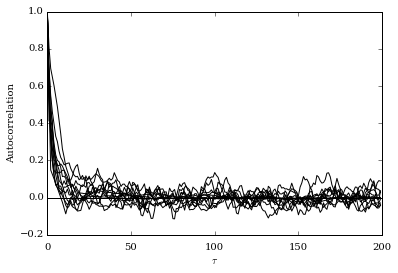

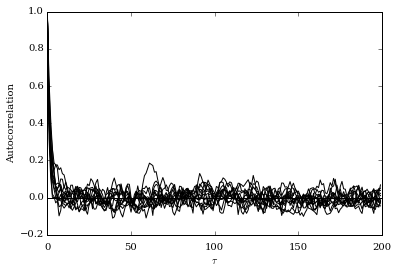

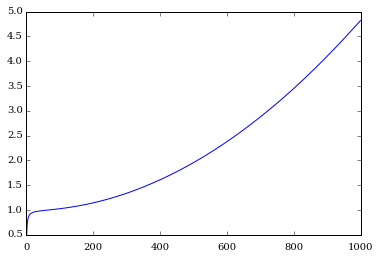

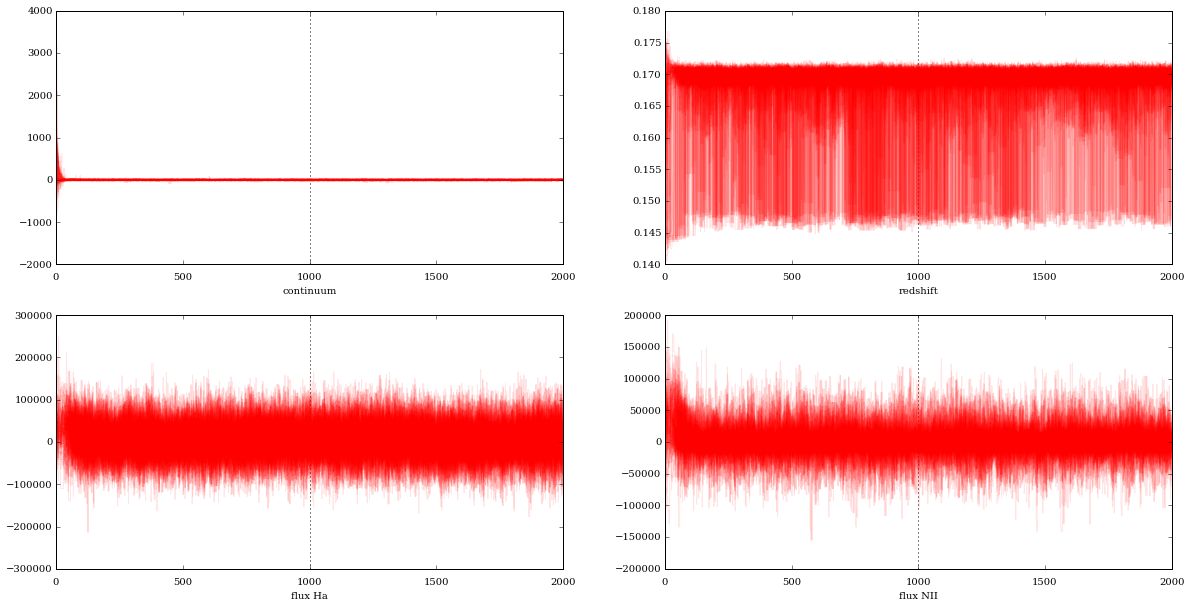

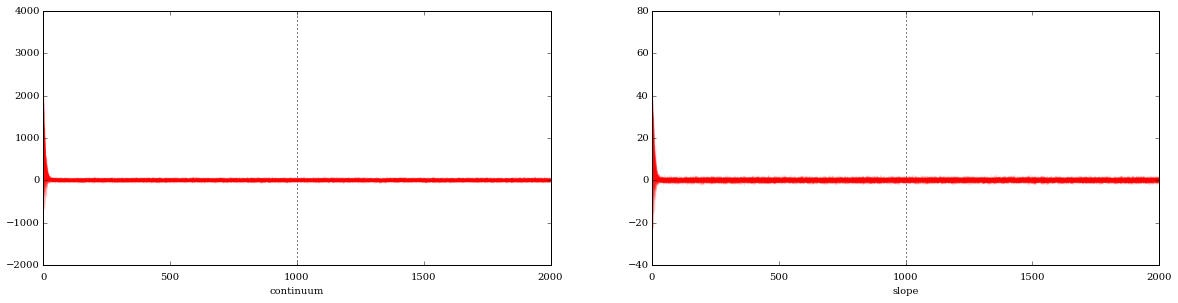

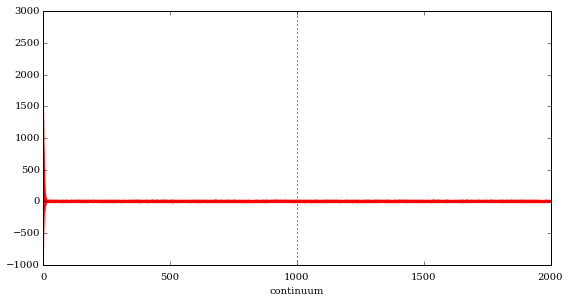

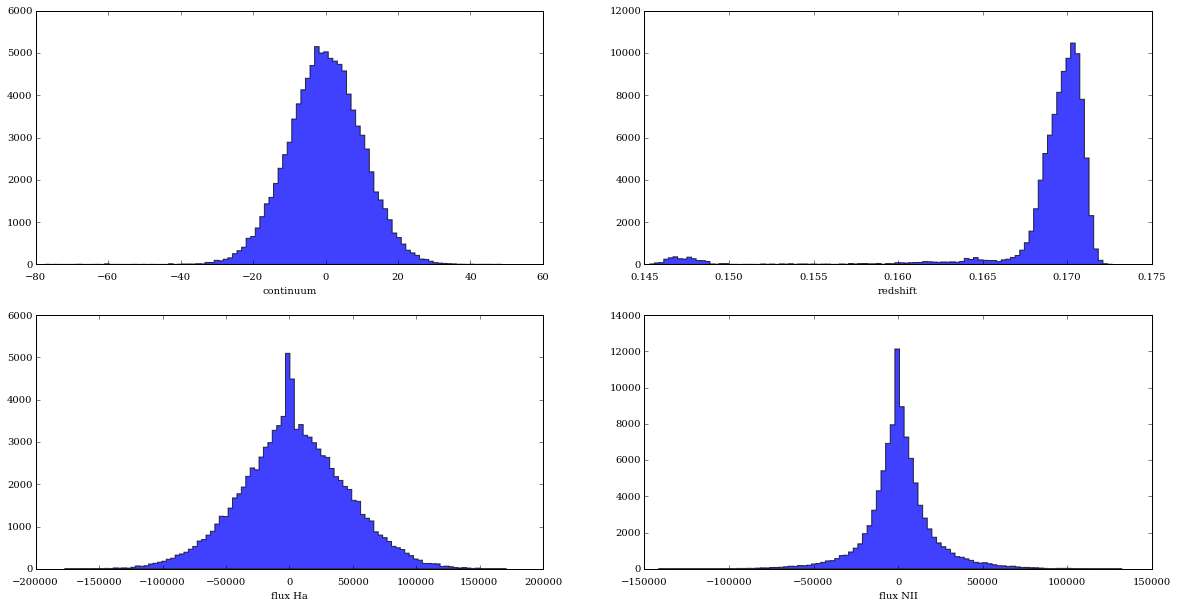

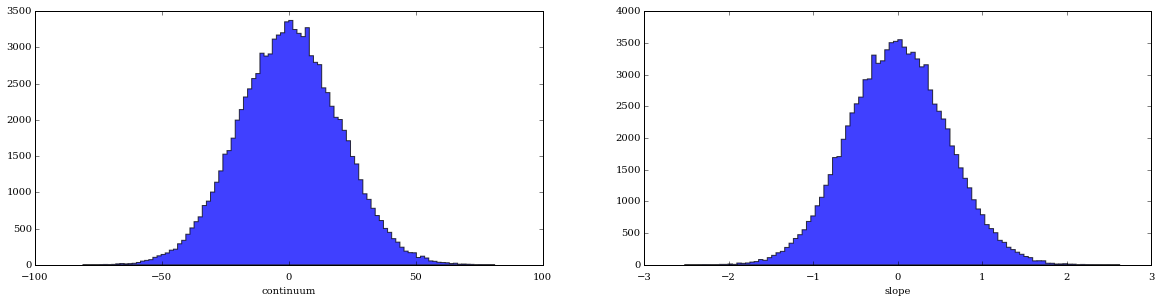

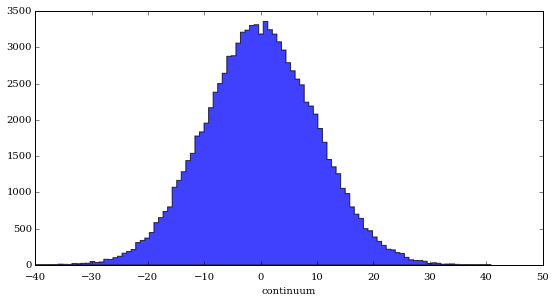

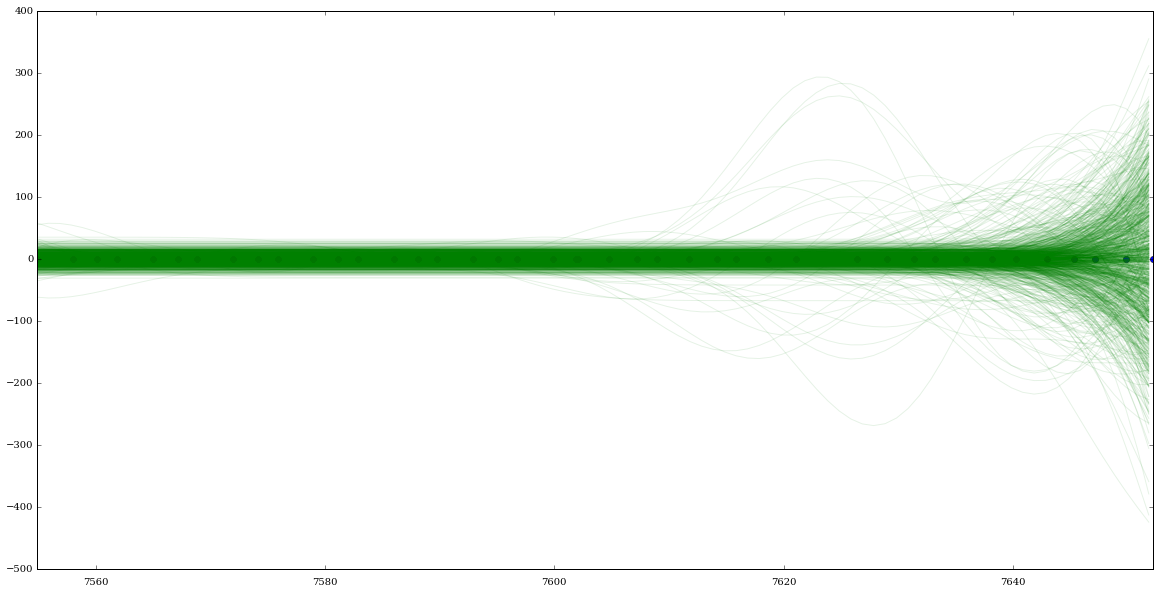

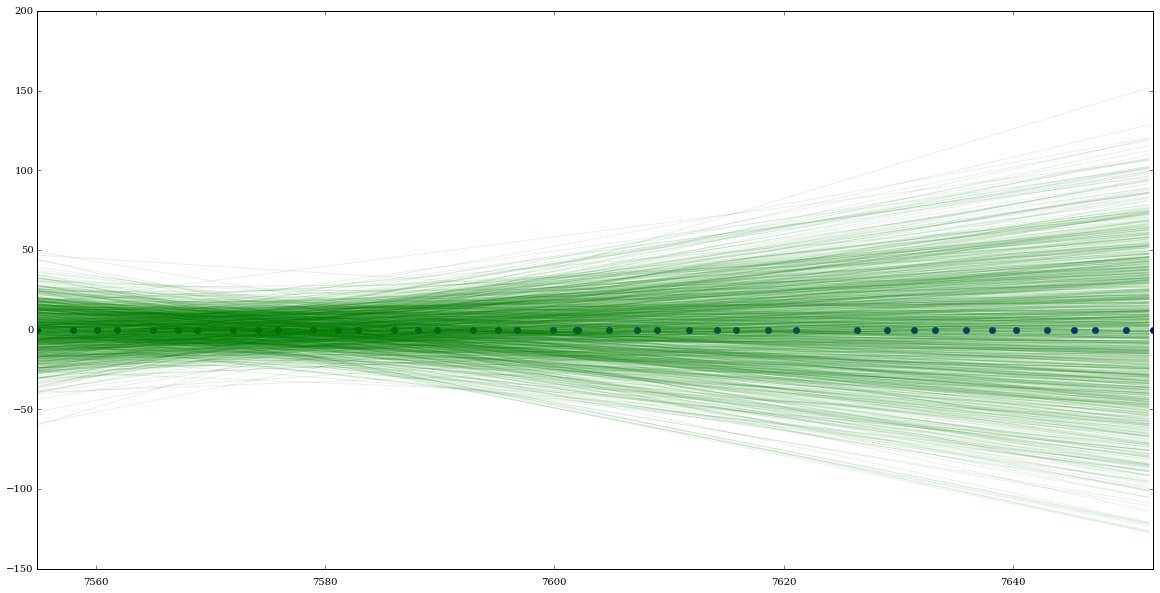

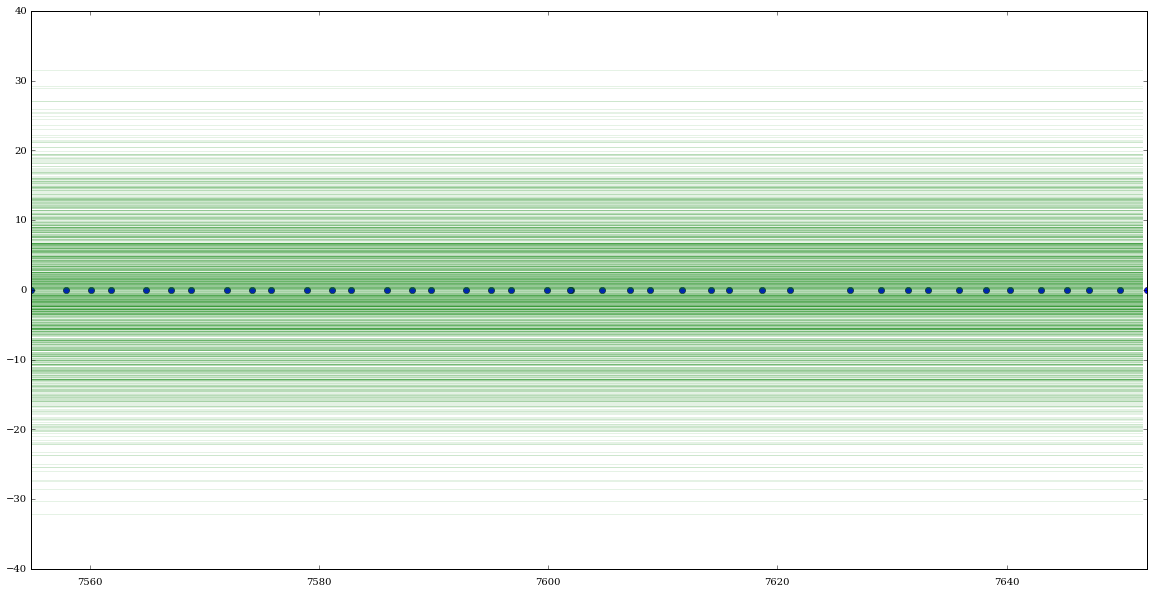

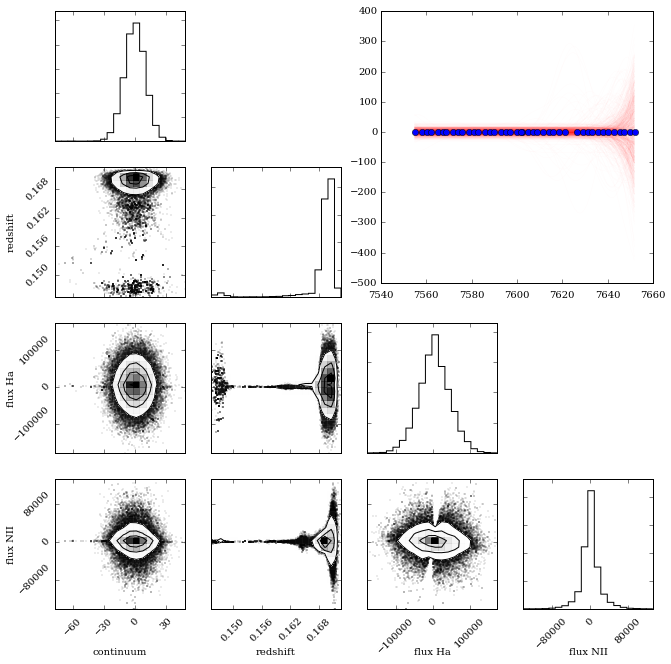

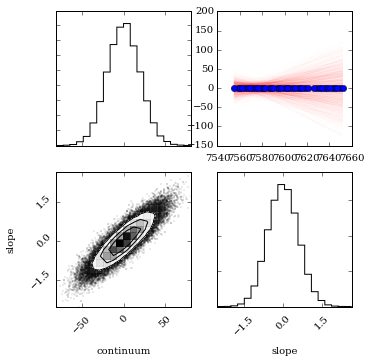

In [33]:
glx = 33185
#glx = 35120
data = get_data(glx)
run_sim(data)
